<a href="https://colab.research.google.com/github/DiegoHuesos/Tesis_deteccion_de_ruido_en_imagenes_con_algoritmo_paralelo_de_agrupamiento/blob/master/Experimentacion_Sklearn_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimentación con algoritmo DBSCAN de la libraría scikit-learn



En el presente código, se llevan a cabo distintos experimentos para medir el tiempo de ejecución y el uso de la memoria al ejecutar el algoritmo [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) de la librería [scikit-learn](https://scikit-learn.org/stable/index.html).

Se llevan a cabo dos experimentos principales: por un lado, se utilizan los conjuntos de datos de muestra (Toy Datasets) de la librería `sklearn`; por otro lado, se utilizan los conjuntos de datos sintéticos creados previamente con la función de `make_blobs()` que viene por defecto en la librería `sklearn`.

En ambos casos, se ejecuta 30 veces la función `DBSCAN()` para cada conjunto de datos, se mide el tiempo de ejecución y el uso de la memoria, y, por último, se guardan los resultados en archivos en formato `JSON` para su posterior análisis en conjunto de otros resultados experimentales.

La razón por la cual se determina que 30 es el número de repeticiones adecuado para la experimentación es porque este es un número comúnmente utilizado en experimentos para obtener una estimación fiable. La justificación estadística para 30 repeticiones se debe a que se considera que proporciona una muestra suficientemente grande para que el Teorema del Límite Central se aplique, permitiendo que se utilicen análisis paramétricos, asumiendo una distribución normal de los resultados.

## Importación de librerías y declaración de funciones para graficar resultados y medir uso de memoria

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import psutil
import os
import gc

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.datasets import make_blobs
from PIL import Image, ImageFilter

In [ ]:
def plot_dbscan_results(df, labels, core_samples_mask, title):
    # Nota: La función asume que 'df' es un DataFrame con al menos dos columnas y que
    # 'labels' es un array de etiquetas de cluster obtenidas de DBSCAN.
    # 'core_samples_mask' es un array booleano que indica si un punto es un core sample.

    # Crea una lista de colores únicos basada en la paleta 'Set2'
    unique_labels = set(labels)
    colors = sns.color_palette('Set2', n_colors=len(unique_labels))

    plt.figure(figsize=(8, 6))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'lightgrey' # El color gris se usará para el ruido (outliers)

        class_member_mask = (labels == k)

        # Graficar los puntos núcleo (core samples)
        xy = df[class_member_mask & core_samples_mask]
        sns.scatterplot(x=xy.iloc[:, 0], y=xy.iloc[:, 1], color=col, s=50, edgecolor='k')

        # Graficar los puntos que no son núcleo (non-core samples)
        xy = df[class_member_mask & ~core_samples_mask]
        sns.scatterplot(x=xy.iloc[:, 0], y=xy.iloc[:, 1], color=col, s=20, edgecolor='k', label=f'Cluster {k}' if k != -1 else 'Noise')

    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.show()

In [ ]:
def get_total_memory():
    return psutil.virtual_memory().total / (1024 * 1024)

def get_memory_usage_percentage():
    return psutil.virtual_memory().percent

def get_cpu_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    return cpu_usage

## Experimentación con Toy Datasets



A continuación, se lleva a cabo la experimentación con los conjuntos de datos de muestra de la librería `sklearn` llamados [Toy Datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html).

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.

Los resultados de este experimento se guardan en el archivo `sklearn_toy_datasets_results.json`.

In [ ]:
# Declarar del diccionario con los conjuntos de datos de Toy Datasets y sus correspondientes valores de eps y num_samples
toy_datasets = {  'iris': {'dataset': datasets.load_iris(), 'eps': 0.199367, 'min_samples': 5},
                  'diabetes': {'dataset': datasets.load_diabetes(), 'eps': 0.014765, 'min_samples': 6},
                  'digits': {'dataset': datasets.load_digits(), 'eps': 1.038251, 'min_samples': 7},
                  'linnerud': {'dataset': datasets.load_linnerud(), 'eps': 41.911597, 'min_samples': 2},
                  'wine': {'dataset': datasets.load_wine(), 'eps': 16.622963, 'min_samples': 5},
                  'breast_cancer': {'dataset': datasets.load_breast_cancer(), 'eps': 42.689478, 'min_samples': 6}
                }

# Iterar por cada conjunto de datos de Toy Datasets
for dataset_name, _ in toy_datasets.items():

    # Imprimir el nombre del conjunto de datos para el control de la ejecución
    print('Dataset: ', dataset_name)

    # Cargar el conjunto de datos
    Y = toy_datasets[dataset_name]['dataset'].data

    # Reducir la dimensión del conjunto de datos a sólo dos características
    pca = PCA(n_components=2)
    X_std = pca.fit_transform(Y)

    # Eliminar el dataset del diccionario y Y
    del Y, toy_datasets[dataset_name]['dataset']
    gc.collect()

    # Obtener los valores de eps y min_samples
    eps = toy_datasets[dataset_name]['eps']
    min_samples = toy_datasets[dataset_name]['min_samples']

    # Almacenar la forma (dimensionalidad) del conjunto de datos e inicializar el diccionario de experimentos
    toy_datasets[dataset_name]['shape'] = X_std.shape
    toy_datasets[dataset_name]['experiment'] = {}

    # Repetir el experimento para poder verificar que siempre de los mismos resultados el algoritmo DBSCAN
    # y obtener tiempos de ejecución y uso de memoria.
    for i in range(30):

      # Obtener tiempo inicial
      start_time = time.time()

      # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
      db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_std)

      # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
      execution_time = time.time() - start_time

      # Obtener los resultados
      labels = db.labels_.tolist()
      n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
      core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
      core_samples_mask[db.core_sample_indices_] = True
      n_core_points = int(sum(core_samples_mask))
      n_noise = int(list(labels).count(-1))

      # Guardar los resultados en el diccionario
      toy_datasets[dataset_name]["experiment"][i] = {
          "execution_time": execution_time,
          "memory_usage": get_memory_usage_percentage(),
          "clusters": n_clusters,
          "core_points": n_core_points,
          "unclassified_points": n_noise,
          "labels": labels
      }

      # Eliminar los resultados de DBSCAN de la memoria RAM
      del db
      gc.collect()

    # Eliminar el conjunto de datos en Y y en X_std de la memoria RAM
    del X_std
    gc.collect()

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'sklearn_toy_datasets_results.json'
with open(file_name, 'w') as file:
    json.dump(toy_datasets, file, indent=4)
    print(f"Resultados guardados en {file_name}")

Dataset:  iris
Dataset:  diabetes
Dataset:  digits
Dataset:  linnerud
Dataset:  wine
Dataset:  breast_cancer


## Conjuntos de datos sintéticos de distintos tamaños



A continuación, se lleva ejecuta el algoritmo `DBSCAN` con los conjuntos de datos sintéticos de distintos tamaños: 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000 y 50000 puntos de dos dimensiones que se generaron utilizando la función `make_blobs` de la librería `sklearn.datasets` y se grafican los resultados.

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.


Dataset:  5000
Dataset shape:  (5000, 2)
Eps: 0.4 Min Samples: 6
Number of Core Points: 4881
Number of Clusters: 2
Number of Unclassified Points: 65


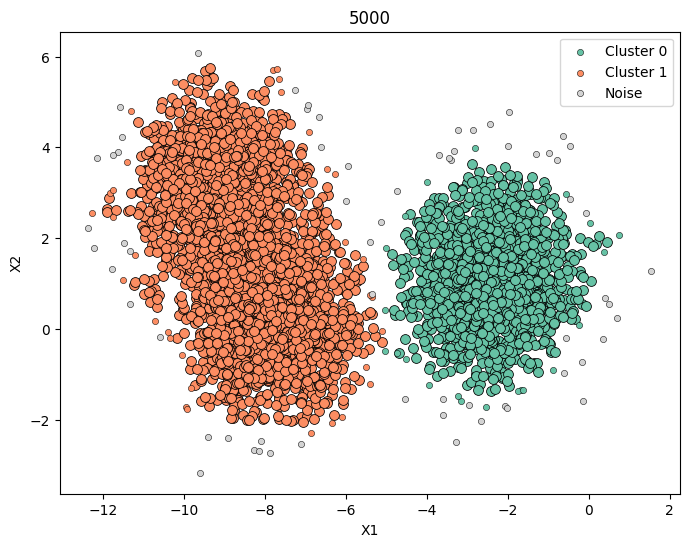


Dataset:  10000
Dataset shape:  (10000, 2)
Eps: 0.6 Min Samples: 5
Number of Core Points: 9957
Number of Clusters: 3
Number of Unclassified Points: 13


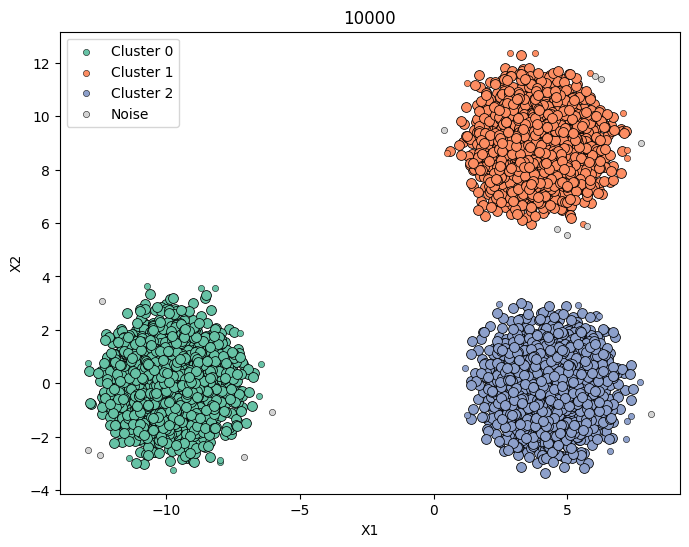


Dataset:  15000
Dataset shape:  (15000, 2)
Eps: 0.8 Min Samples: 4
Number of Core Points: 14994
Number of Clusters: 2
Number of Unclassified Points: 2


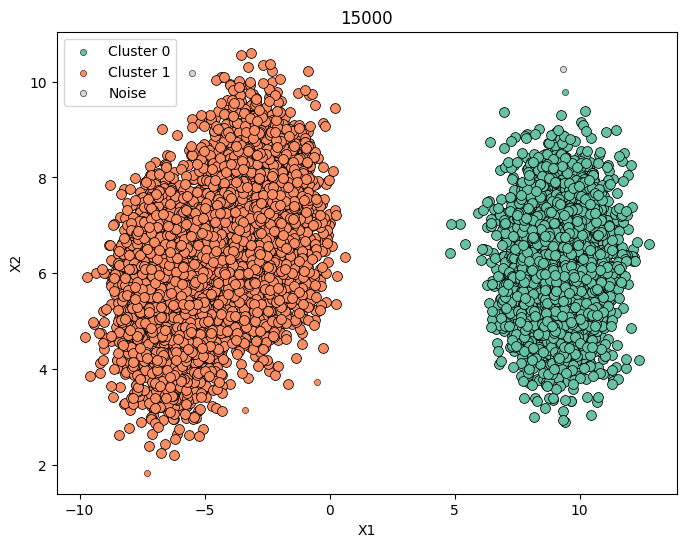


Dataset:  20000
Dataset shape:  (20000, 2)
Eps: 0.8 Min Samples: 6
Number of Core Points: 19985
Number of Clusters: 2
Number of Unclassified Points: 2


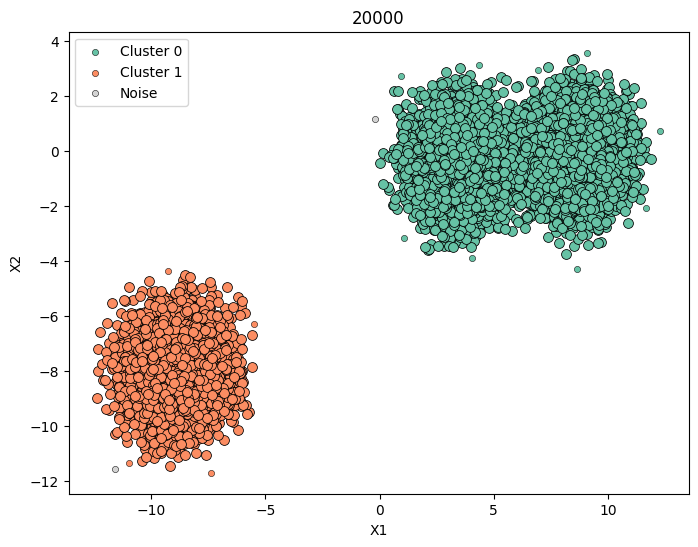


Dataset:  25000
Dataset shape:  (25000, 2)
Eps: 0.9 Min Samples: 4
Number of Core Points: 24990
Number of Clusters: 2
Number of Unclassified Points: 2


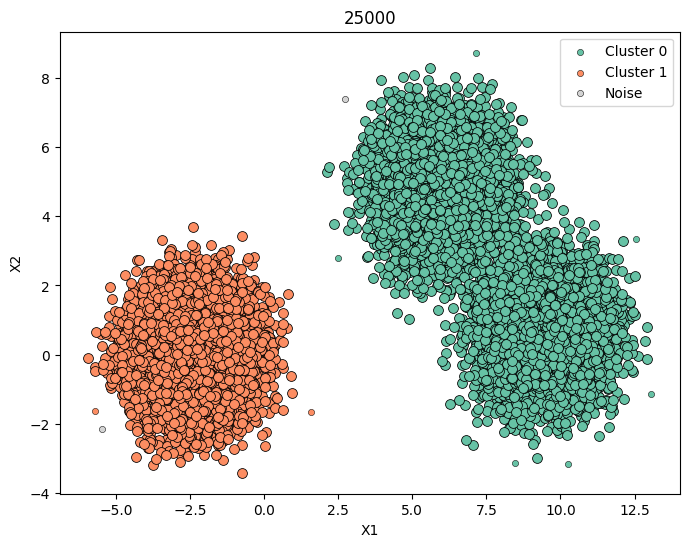


Dataset:  30000
Dataset shape:  (30000, 2)
Eps: 0.8 Min Samples: 2
Number of Core Points: 29998
Number of Clusters: 2
Number of Unclassified Points: 2


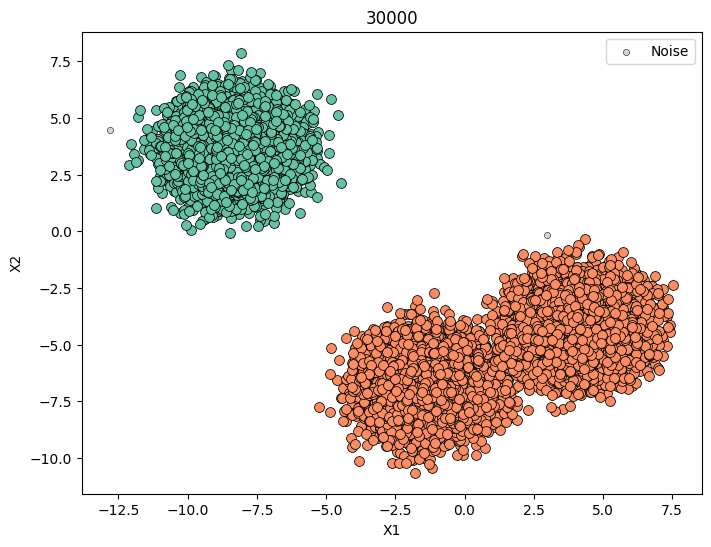


Dataset:  35000
Dataset shape:  (35000, 2)
Eps: 0.8 Min Samples: 3
Number of Core Points: 34991
Number of Clusters: 2
Number of Unclassified Points: 4


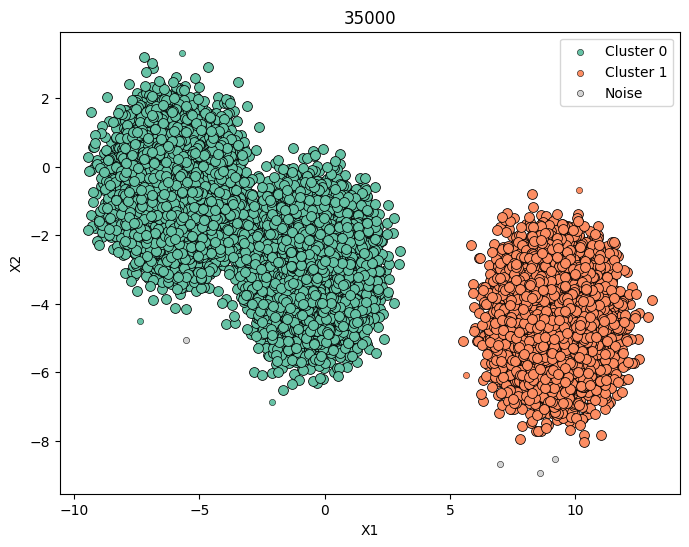


Dataset:  40000
Dataset shape:  (40000, 2)
Eps: 0.8 Min Samples: 5
Number of Core Points: 39983
Number of Clusters: 2
Number of Unclassified Points: 6


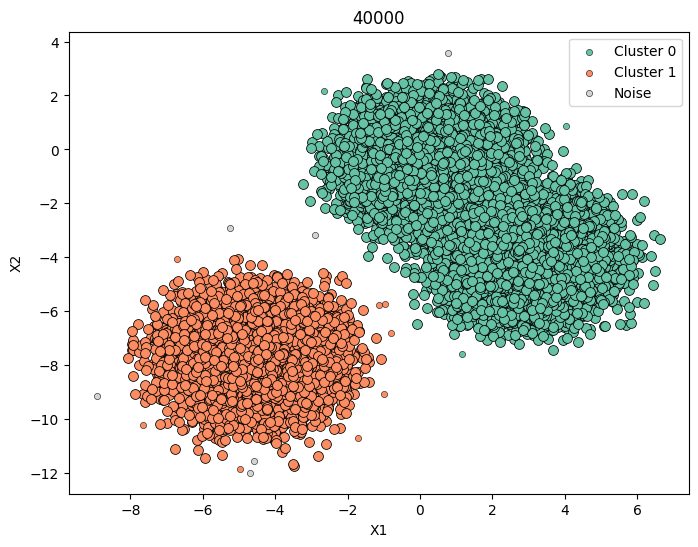


Dataset:  45000
Dataset shape:  (45000, 2)
Eps: 0.8 Min Samples: 9
Number of Core Points: 44974
Number of Clusters: 2
Number of Unclassified Points: 6


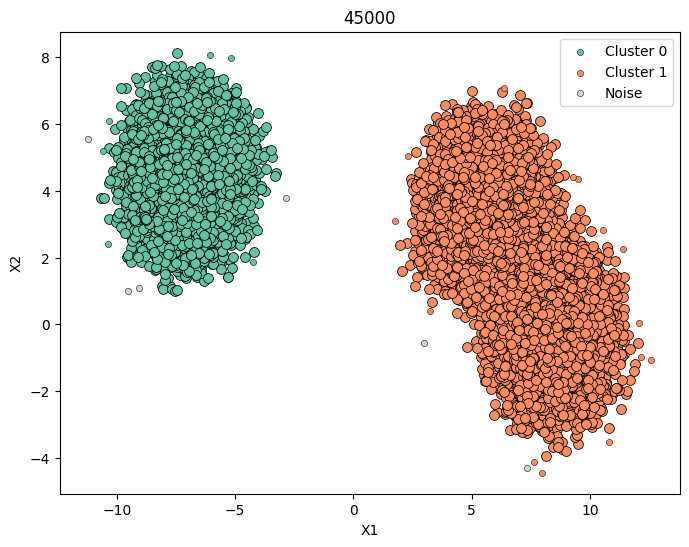


Dataset:  50000
Dataset shape:  (50000, 2)
Eps: 0.6 Min Samples: 6
Number of Core Points: 49943
Number of Clusters: 3
Number of Unclassified Points: 19


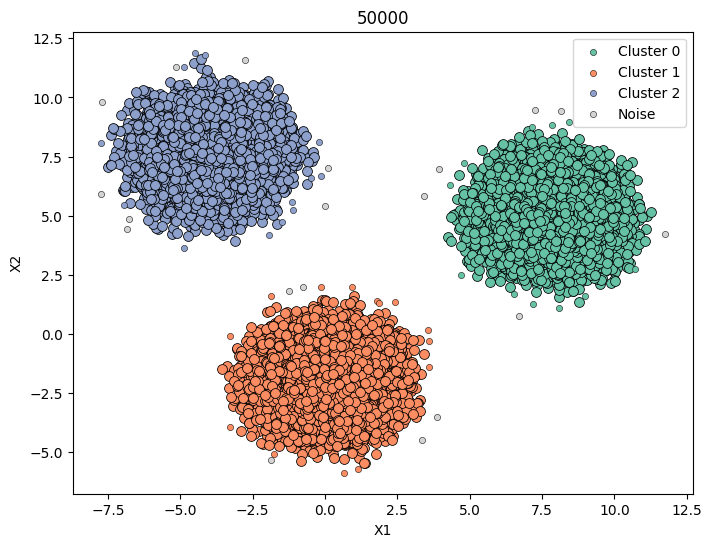

In [ ]:
# Declarar los valores de eps y num_samples óptimos para cada conjunto de datos
datasets_eps_min_samples = {
                                5000: {'epsilon': 0.4, 'min_samples': 6},
                                10000: {'epsilon': 0.6, 'min_samples': 5},
                                15000: {'epsilon': 0.8, 'min_samples': 4},
                                20000: {'epsilon': 0.8, 'min_samples': 6},
                                25000: {'epsilon': 0.9, 'min_samples': 4},
                                30000: {'epsilon': 0.8, 'min_samples': 2},
                                35000: {'epsilon': 0.8, 'min_samples': 3},
                                40000: {'epsilon': 0.8, 'min_samples': 5},
                                45000: {'epsilon': 0.8, 'min_samples': 9},
                                50000: {'epsilon': 0.6, 'min_samples': 6}
                            }

# Diccionario para almacenar los resultados de cada conjunto de datos
all_results = {}

# Iterar por cada conjunto de datos
for num_samples in range(5000, 50001, 5000):
    filename = f'./datasets/dataset_{num_samples}.json'
    with open(filename, 'r') as f:
        data = json.load(f)

    dataset_name = str(num_samples)
    X = np.array(data[dataset_name])
    eps = datasets_eps_min_samples[num_samples]['epsilon']
    min_samples = datasets_eps_min_samples[num_samples]['min_samples']

    del data
    gc.collect()

    start_time = time.time()
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    execution_time = time.time() - start_time

    # Obtener los resultados
    labels = db.labels_
    n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    n_core_points = int(sum(core_samples_mask))
    n_noise = int(list(labels).count(-1))

    # Imprimir los resultados
    print("\nDataset: ", dataset_name)
    print("Dataset shape: ", X.shape)
    print("Eps:", eps, "Min Samples:", min_samples)
    print("Number of Core Points:", n_core_points)
    print("Number of Clusters:", n_clusters)
    print("Number of Unclassified Points:", n_noise)

    # Graficar los resultados (asegúrate de que la función plot_dbscan_results esté definida)
    df = pd.DataFrame(X, columns=['X1', 'X2'])
    plot_dbscan_results(df, labels, core_samples_mask, dataset_name)

    # Guardar los resultados en el diccionario
    all_results[dataset_name] = {
        'num_clusters': n_clusters,
        'num_core_points': n_core_points,
        'num_noise': n_noise,
        'labels': labels.tolist(),
        'core_samples_mask': core_samples_mask.tolist(),
        'data': X.tolist(),
    }

    del X, db
    gc.collect()

# Guardar los resultados en un archivo JSON
with open('different_sizes_data_and_solution_labels.json', 'w') as outfile:
    json.dump(all_results, outfile, indent=4)

## Experimentación con conjuntos de datos sintéticos de distintos tamaños

A continuación, se lleva a cabo la experimentación con los conjuntos de datos sintéticos de distintos tamaños: 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000 y 50000 puntos de dos dimensiones que se generaron utilizando la función `make_blobs` de la librería `sklearn.datasets`.

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.

Los resultados de este experimento se guardan en el archivo `sklearn_different_size_results.json`.

In [ ]:
# Declarar los valores de eps y min_samples óptimos para cada conjunto de datos
datasets_eps_min_samples = {  5000: {'epsilon': 0.4, 'min_samples': 6},
                              10000: {'epsilon': 0.6, 'min_samples': 5},
                              15000: {'epsilon': 0.8, 'min_samples': 4},
                              20000: {'epsilon': 0.8, 'min_samples': 6},
                              25000: {'epsilon': 0.9, 'min_samples': 4},
                              30000: {'epsilon': 0.8, 'min_samples': 2},
                              35000: {'epsilon': 0.8, 'min_samples': 3},
                              40000: {'epsilon': 0.8, 'min_samples': 5},
                              45000: {'epsilon': 0.8, 'min_samples': 9},
                              50000: {'epsilon': 0.6, 'min_samples': 6} }

# Declarar diccionario para almacenar los resultados de la experimentación
different_size_datasets = {}

# Iterar por cada conjunto de datos
for num_samples in range(5000, 50001, 5000):

    # Imprimir el nombre del conjunto de datos para el control de la ejecución
    print('Dataset: ', num_samples)

    # Construir el nombre del archivo JSON del dataset correspondiente
    filename = './datasets/dataset_' + str(num_samples) + '.json'

    # Abrir el archivo JSON correspondiente para cargar los datos del conjunto de datos correspondiente
    with open(filename, 'r') as f:
        data = json.load(f)

    # Obtener los datos, el valor eps y min_samples
    dataset_name = str(num_samples)
    X = np.array(data[dataset_name])
    eps = datasets_eps_min_samples[num_samples]['epsilon']
    min_samples = datasets_eps_min_samples[num_samples]['min_samples']

    # Borrar data de la memoria RAM
    del data
    gc.collect()

    # Guardar los resultados en el diccionario
    different_size_datasets[num_samples] = {}
    different_size_datasets[num_samples]['experiment'] = {}

    # Repetir el experimento para poder verificar que siempre de los mismos resultados el algoritmo DBSCAN
    # y obtener tiempos de ejecución y uso de memoria.
    for i in range(30):

      # Obtener tiempo inicial
      start_time = time.time()

      # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
      db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

      # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
      execution_time = time.time() - start_time

      # Obtener los resultados
      labels = db.labels_.tolist()
      n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
      core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
      core_samples_mask[db.core_sample_indices_] = True
      n_core_points = int(sum(core_samples_mask))
      n_noise = int(list(labels).count(-1))

      # Guardar los resultados en el diccionario
      different_size_datasets[num_samples]["experiment"][i] = {
          "execution_time": execution_time,
          "memory_usage": get_memory_usage_percentage(),
          "clusters": n_clusters,
          "core_points": n_core_points,
          "unclassified_points": n_noise
      }

      # Eliminar los resultados de DBSCAN de la memoria RAM
      del db
      gc.collect()

    # Eliminar el conjunto de datos en X de la memoria RAM
    del X
    gc.collect()

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'sklearn_different_size_results.json'
with open(file_name, 'w') as file:
    json.dump(different_size_datasets, file, indent=4)
    print(f"Resultados guardados en {file_name}")

Dataset:  5000
Dataset:  10000
Dataset:  15000
Dataset:  20000
Dataset:  25000
Dataset:  30000
Dataset:  35000
Dataset:  40000
Dataset:  45000
Dataset:  50000
Resultados guardados en sklearn_different_size_results.json
